Read in files...

In [ ]:
import pandas as pd
dev_df = pd.read_csv("dev.input-label", sep="\t")
test_df = pd.read_csv("test.input-label", sep="\t")
train_df = pd.read_csv("train.input-label", sep="\t")

In [ ]:
pip install bpemb

Create Byte pair embeddings

In [ ]:
from bpemb import BPEmb
multibpemb = BPEmb(lang="multi", vs=100000, dim=300)

In [ ]:
#https://bpemb.h-its.org/
def subword(text):
  doc = open("dev.tsv", "w")
  for i, j in text.iterrows():
    subwords = multibpemb.encode(j[0])
    subwords = str(subwords)
    doc.write(str(subwords) + "\t" + str(j[1]) + "\n")

In [ ]:
subword(dev_df)
#subword(test_df)
#subword(train_df)

In [ ]:
dev_new = pd.read_csv("dev.tsv", sep="\t")
test_new = pd.read_csv("test.tsv", sep="\t")
train_new = pd.read_csv("train.tsv", sep="\t")


In [ ]:
print(dev_new)

     ['▁', '【', '▁', '時', '報', '】', '午', '後', '▁0', '時', 'な', 'ので', 'す', '。', 'この', '時間', 'は', '眠', 'く', 'なる', 'ので', 'す', '▁...']  ja
0     ['▁የ', 'ም', 'ታ', 'ው', 'ቀ', 'ው', '▁የ', 'ይ', 'ሖ'...                                                                            am
1     ['▁no', '▁voy', '▁a', '▁ir', '▁a', '▁bus', 'ca...                                                                            lv
2     ['▁@', 'rev', 'ij', 'are', 'porter', '▁raz', '...                                                                            sl
3     ['▁lang', 'ar', '▁ekki', '▁í', '▁range', '▁rov...                                                                            is
4     ['▁دع', 'اء', '▁الس', 'ج', 'ود', ':', 'سب', 'ح...                                                                            ar
...                                                 ...                                                                            ..
6962  ['▁por', '▁eso', '▁llam', 'é', '▁victory', '▁(...       

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline
import torchtext
from torchtext import data, datasets
import random
from torch import optim
import math
from collections import Counter
from tqdm import tqdm, trange
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"

#create field objects
TEXT = torchtext.legacy.data.Field(init_token = BOS_WORD, eos_token = EOS_WORD)
LABEL = torchtext.legacy.data.Field(init_token = BOS_WORD, eos_token = EOS_WORD)

#create tuples representing the colums
fields = [("text", TEXT), ("label", LABEL)]


train, val, test = torchtext.legacy.data.TabularDataset.splits(
                                             path = '', train = "train.tsv", validation = "dev.tsv", 
                                             test = "test.tsv", format = "tsv", fields = fields, skip_header = True)

print(vars(train[0]))


{'text': ["['▁user',", "'▁era',", "'▁una',", "'▁preg',", "'unta',", "'▁ret',", "'òr',", "'ica',", "'▁.',", "'▁em',", "'▁dó',", "'na',", "'▁igual',", "'▁si',", "'▁pot',", "'s',", "'▁o',", "'▁no',", "'▁sor',", "'tir',", "'▁de',", "'▁casa',", "'▁.']"], 'label': ['ca']}


In [ ]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of validation examples: {len(val.examples)}")
print(f"Number of testing examples: {len(test.examples)}")

Number of training examples: 34890
Number of validation examples: 6967
Number of testing examples: 7120


In [ ]:
#https://dzlab.github.io/dltips/en/pytorch/torchtext-datasets/
from torchtext.legacy.data import Iterator
MIN_FREQ = 2
TEXT.build_vocab(train.text, min_freq=MIN_FREQ)
LABEL.build_vocab(train.label, min_freq=MIN_FREQ)

# determine what device to use
device = torch.device(
  'cuda' if torch.cuda.is_available() else 'cpu'
)

# create iterators for train/valid/test datasets
train_iter, dev_iter, test_iter = torchtext.legacy.data.BucketIterator.splits(
  (train, val, test),
  sort_key = lambda x: x.text,
  sort_within_batch=False,
  batch_size = 32,
  device = device
)

In [ ]:
TEXT.vocab.stoi["<blank>"]

0

In [ ]:
print(f"Unique tokens in text vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in label vocabulary: {len(LABEL.vocab)}")

Unique tokens in text vocabulary: 56054
Unique tokens in label vocabulary: 81


In [ ]:
for batch in train_iter:
    print(batch)
    txt = batch.text
    lbl = batch.label
    print('tensor size of text:', txt.shape)
    print('tensor size of label:', lbl.shape)
    print('the tensor of first example in lbl:', lbl[:,0])
    break
    


[torchtext.legacy.data.batch.Batch of size 32]
	[.text]:[torch.cuda.LongTensor of size 75x32 (GPU 0)]
	[.label]:[torch.cuda.LongTensor of size 3x32 (GPU 0)]
tensor size of text: torch.Size([75, 32])
tensor size of label: torch.Size([3, 32])
the tensor of first example in lbl: tensor([ 2, 65,  3], device='cuda:0')


In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the position encoding function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

Now we build our Transformer model. Transformers use a specific type of attention mechanism, referred to as multi-head attention. The attention layer determines which elements we “pay attention” to. The attention array is normalized using softmax, so that all of the weights sum to one, since we can’t pay more than 100% attention. 

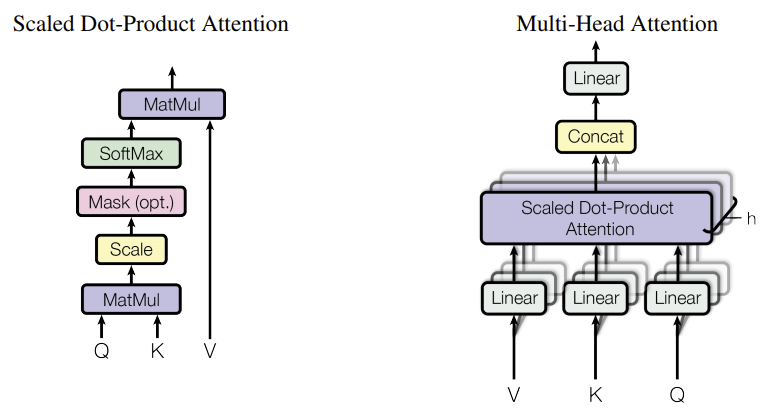

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

From the diagram above, we see that the multi-head attention is composed of several identical attention heads. Next we code the MultiHeadAttention comprising multiple identical attention:

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

Next we build the Transformer model. 

In [ ]:
class Transformer(nn.Module):
  def __init__(self, src_vocab, trg_vocab, embed_dim, nhead, num_encoder_layers, dropout, num_decoder_layers, dim_feedforward):
    super(Transformer, self).__init__()
    # get initial hyper-parameters
    self.src_vocab = src_vocab
    self.trg_vocab = trg_vocab
    self.embed_dim = embed_dim
    self.nhead = nhead
    self.num_encoder_layers = num_encoder_layers
    self.dropout = dropout
    self.num_decoder_layers = num_decoder_layers
    self.dim_feedforward = dim_feedforward
    # add embedding layers
    self.embedding_encoder = nn.Embedding(self.src_vocab, self.embed_dim)
    self.embedding_decoder = nn.Embedding(self.trg_vocab , self.embed_dim)
    # Encoder-Decoder Transformer
    self.transformer = nn.Transformer(d_model= self.embed_dim,nhead=self.nhead, num_encoder_layers=self.num_encoder_layers, dropout=self.dropout, num_decoder_layers=self.num_decoder_layers, dim_feedforward=self.dim_feedforward)
    
    # output layer to predict next token
    self.decoder = nn.Linear(self.embed_dim, self.trg_vocab)

  def forward(self, src, tgr):
    # embedding layer
    src = self.embedding_encoder(src)
    tgr = self.embedding_decoder(tgr)

    # Transformer
    output = self.transformer(src, tgr)

    # predication 
    output = self.decoder(output) 
    return F.softmax(output, dim=1)

We 

In [ ]:
txt_vocab = len(TEXT.vocab)
lbl_vocab = len(LABEL.vocab)
print(txt_vocab, lbl_vocab)
embed_dim = 128
nhead = 2
num_encoder_layers = 1
dropout = 0.5 
num_decoder_layers = 1
dim_feedforward = 128

model = Transformer(txt_vocab, lbl_vocab, embed_dim, nhead, num_encoder_layers, dropout, num_decoder_layers,dim_feedforward).to(device)

56054 81


## Create the batches

In [ ]:
for batch in train_iter:
    txt = batch.text
    lbl = batch.label
    model(txt,lbl)
    
    print('tensor size of source language:', txt.shape)
    print('tensor size of target language:', lbl.shape)
    print('the tensor of first example in target language:', lbl[:,0])
    break

tensor size of source language: torch.Size([90, 32])
tensor size of target language: torch.Size([3, 32])
the tensor of first example in target language: tensor([2, 8, 3], device='cuda:0')


## Training the model

In [ ]:
def train(model, iterator, optimizer, criterion):
    manual_seed = 77
    total_acc = 0
    total_count = 0
    torch.manual_seed(manual_seed)
    if n_gpu > 0:
        torch.cuda.manual_seed(manual_seed)
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        txt = batch.text
        lbl = batch.label
        
        optimizer.zero_grad()
        
        output = model(txt, lbl)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        lbl = lbl[1:].view(-1)
        # loss function works only 2d logits, 1d targets
        # so flatten the trg, output tensors. Ignore the <sos> token
        # trg shape shape should be [(sequence_len - 1) * batch_size]
        # output shape should be [(sequence_len - 1) * batch_size, output_dim]
        
        loss = criterion(output, lbl)
        
        loss.backward()

        optimizer.step()

        total_acc += (output.argmax(1) == lbl).sum().item()
        total_count += lbl.size(0)
        
        epoch_loss += loss.item()

    return (total_acc / total_count), epoch_loss / len(iterator)

## Evaluate the Model

In [ ]:
def evaluate(model, iterator, criterion):

    total_acc = 0
    total_count = 0

    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            txt = batch.text
            lbl = batch.label

            output = model(txt, lbl) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            lbl = lbl[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            total_acc += (output.argmax(1) == lbl).sum().item()
            total_count += lbl.size(0)

            loss = criterion(output, lbl)

            epoch_loss += loss.item()
        
    return (total_acc / total_count), epoch_loss / len(iterator)

In [ ]:
def init_weights(m):
    manual_seed = 77
    torch.manual_seed(manual_seed)
    if n_gpu > 0:
        torch.cuda.manual_seed(manual_seed)
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.05)
        else:
            nn.init.constant_(param.data, 0)

### Keep track of the time for training

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
manual_seed = 77
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

cuda


In [ ]:
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
lbl_pad_idx = LABEL.vocab.stoi[LABEL.pad_token]
print('<pad> token index: ', lbl_pad_idx)
## we will ignor the pad token in true target set
criterion = nn.CrossEntropyLoss(ignore_index = lbl_pad_idx)

<pad> token index:  1


## Training loop

In [ ]:
N_EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_acc, train_loss = train(model, train_iter, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, dev_iter, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Create checkpoint at end of each epoch
    state_dict_model = model.state_dict() 
    state = {
        'epoch': epoch,
        'state_dict': state_dict_model,
        'optimizer': optimizer.state_dict()
        }

    # torch.save(state, "./drive/My Drive/Colab Notebooks/ckpt_ex1/seq2seq_"+str(epoch+1)+".pt")

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Accuracy: {train_acc:.3f} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Valid Accuracy: {valid_acc:.3f} | Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01 | Time: 0m 12s
	 Train Accuracy: 0.007 | Train Loss: 4.395 | Train PPL:  81.017
	 Valid Accuracy: 0.006 | Val. Loss: 4.394 |  Val. PPL:  81.000
Epoch: 02 | Time: 0m 12s
	 Train Accuracy: 0.008 | Train Loss: 4.395 | Train PPL:  81.008
	 Valid Accuracy: 0.006 | Val. Loss: 4.394 |  Val. PPL:  81.000
Epoch: 03 | Time: 0m 12s
	 Train Accuracy: 0.007 | Train Loss: 4.394 | Train PPL:  81.003
	 Valid Accuracy: 0.007 | Val. Loss: 4.394 |  Val. PPL:  81.000
Epoch: 04 | Time: 0m 12s
	 Train Accuracy: 0.007 | Train Loss: 4.395 | Train PPL:  81.007
	 Valid Accuracy: 0.009 | Val. Loss: 4.394 |  Val. PPL:  81.000
Epoch: 05 | Time: 0m 12s
	 Train Accuracy: 0.007 | Train Loss: 4.395 | Train PPL:  81.009
	 Valid Accuracy: 0.008 | Val. Loss: 4.394 |  Val. PPL:  81.000
Epoch: 06 | Time: 0m 12s
	 Train Accuracy: 0.007 | Train Loss: 4.395 | Train PPL:  81.007
	 Valid Accuracy: 0.006 | Val. Loss: 4.394 |  Val. PPL:  81.002
Epoch: 07 | Time: 0m 12s
	 Train Accuracy: 0.007 | Train Loss: 4.395 | Train